In [7]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [8]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils
from ssdmultibox.plotting import *

import matplotlib.pyplot as plt
plt.ion()

In [9]:
device

device(type='cuda', index=0)

In [10]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [11]:
model = SSDModel().to(device)

path = 'model_checkpoints/model-2018-12-15T13:17:36.cpkt'
model.load_state_dict(torch.load(path))

In [12]:
LR = 1e-3
SSD_LOSS_ALPHA = .2

criterion = SSDLoss(alpha=SSD_LOSS_ALPHA)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
current_time = time.time()

In [13]:
train_dataset = TrainPascalFlatDataset()

len(train_dataset)

2501

In [14]:
NUM_WORKERS = utils.get_cpu_count()
BATCH = 16
SHUFFLE = True
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TrainPascalFlatDataset at 0x7fc2527a9be0>,
 'batch_size': 16,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7fc2845dba90>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7fc2845dba58>,
 '_DataLoader__initialized': True}

In [15]:
EPOCHS = 1

for epoch in range(EPOCHS):
    scheduler.step()
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())
        break
    break

pos_loss: 415.7569 neg_hard_mining_loss: 22.7103
n: 104.0 bbs_loss: 1543.0538 cats_loss: 438.4672
epoch: 0 step: 0 loss: 19.0531 time: 37.1729



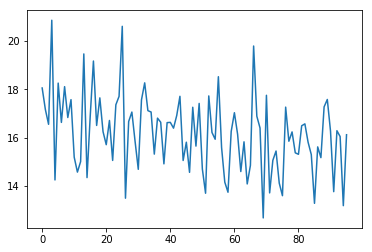

In [45]:
plt.plot(losses['total'])

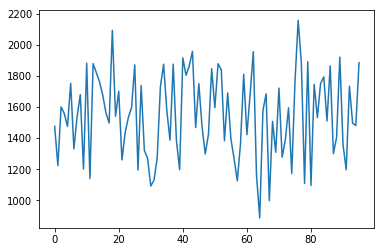

In [46]:
plt.plot(losses['loc'])

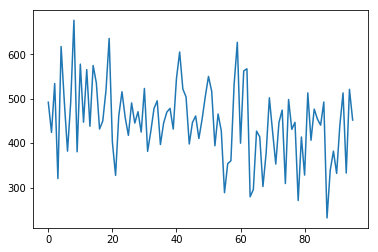

In [47]:
plt.plot(losses['conf'])

In [48]:
utils.save_model(model)

model saved at: model_checkpoints/model-2018-12-12T10:23:41.cpkt


In [16]:
bbs_preds, cats_preds = preds
idx = 1
cls_id = 6
dataset = train_dataset
model_output = image_ids, ims, gt_bbs, gt_cats

## plotting

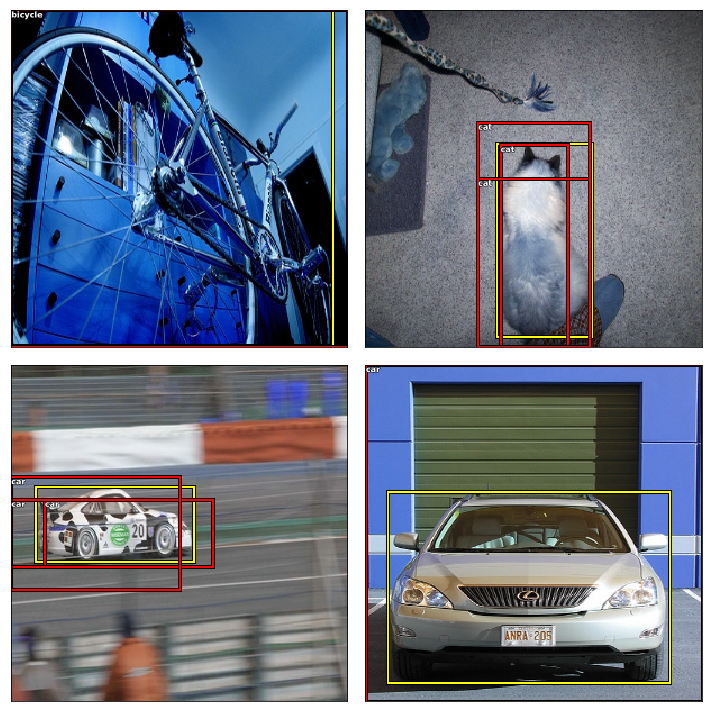

In [18]:
plot_multiple(transform_plot_anchor_bbs, model_output=model_output, dataset=dataset)

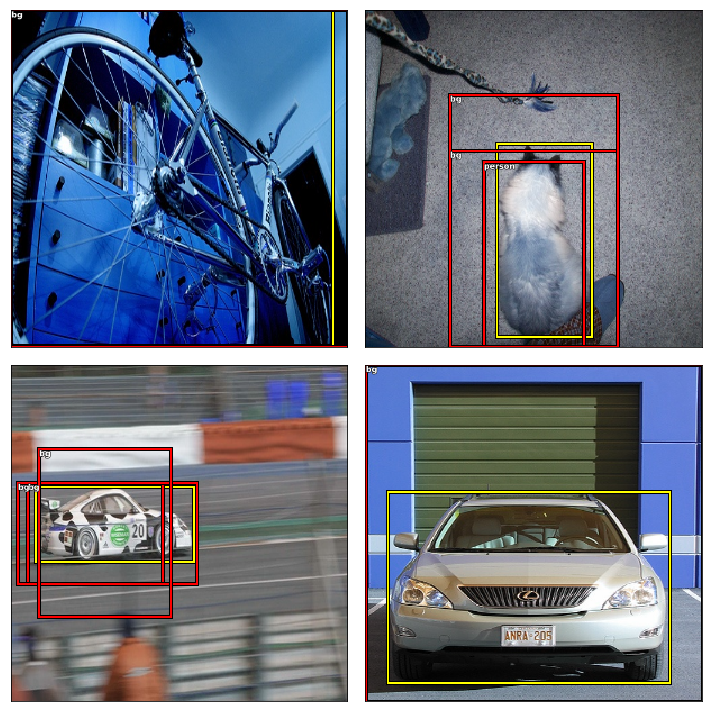

In [19]:
plot_multiple(transform_plot_preds, model_output=model_output, dataset=dataset, preds=preds)

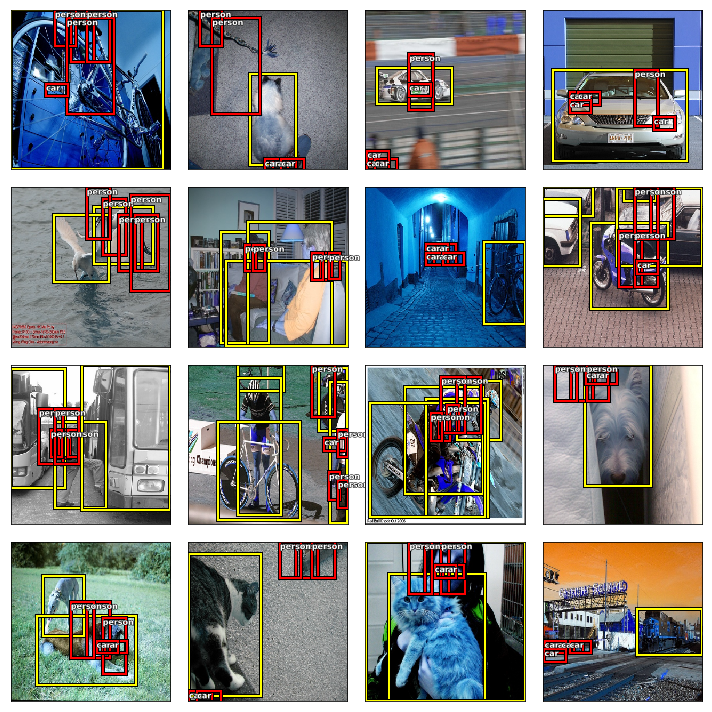

In [20]:
plot_multiple(transform_plot_nms_preds, plots=(4,4), model_output=model_output, dataset=dataset, preds=preds)